# Shap Values

La interpretabilidad de los modelos es un "tema caliente", en muchas ocasiones no podremos entregar un modelo que sea una caja negra, donde no podamos explicar que está pasando realmente. 

En ciertas aréas es particularmente dificil adoptar modelos que sean cajas negras (medicina, banca, ... ), por lo tanto, cuanto mejor sea la interpretabilidad del modelo, mejor adopción tendremos.

Para conseguir esta interpretabilidad de los modelos, podemos utilizar distintas herramientas: 

  - **Shap Values**
  - Lime
  - InterpretML
  - ELI5
  
A lo largo de este tema nos vamos a centrar en la primera, los SHAP Values.

![](img/shap.svg)

SHAP significa **SHapley Additive exPlanations**, de este modo, para entender que son los SHAP values tenemos que saver que es un Shapley value. 

Un SHapley value es la media de las contribuciones marginales de cada elemento en las diferentes permutaciones de estos [Definicion matemática](https://math.stackexchange.com/questions/111580/shapley-value-formula#:~:text=I%20understand%20Shapley%20value%20in,%E2%88%92v(s)).

Una vez conocemos que es un SHapley value, vamos a ver que es SHAP:

[Lundberg & Lee (2016)](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) propusieron el SHAP value como una aproximación unida para explicar los resultados de cualquier modelo de machine learning, otorgandonos los siguientes beneficios: 

1. Interpretabilidad global. Los valores agregados de SHAP values nos indica cuanto contribuye cada predictor.
1. Interpretabilidad local. Cada observacion tiene su conjunto de SHAP values, lo que nos da transparencia.
1. Posibilidad de calcular SHAP para cualquier modelo basado en arboles.

Dicho esto, vamos a ver como visualizar la explicabilidad de los modelos con SHAP en python.

## 1 - importamos las librerías de base

In [1]:
## common libraries for Data Wrangling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn: train test split, RandomForestRegressor, y mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## import shap
import shap

## Carga los datos en un df

In [2]:
df = pd.read_csv('data/winequality-red.csv', sep=';')

In [3]:
df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
147,7.6,0.490,0.26,1.6,0.236,10.0,88.0,0.99680,3.11,0.80,9.3,5
1213,9.6,0.380,0.42,1.9,0.071,5.0,13.0,0.99659,3.15,0.75,10.5,6
954,7.6,0.430,0.40,2.7,0.082,6.0,11.0,0.99538,3.44,0.54,12.2,6
752,7.6,0.540,0.13,2.5,0.097,24.0,66.0,0.99785,3.39,0.61,9.4,5
802,5.1,0.585,0.00,1.7,0.044,14.0,86.0,0.99264,3.56,0.94,12.9,7
80,6.2,0.450,0.20,1.6,0.069,3.0,15.0,0.99580,3.41,0.56,9.2,5
1226,7.5,0.580,0.03,4.1,0.080,27.0,46.0,0.99592,3.02,0.47,9.2,5
13,7.8,0.610,0.29,1.6,0.114,9.0,29.0,0.99740,3.26,1.56,9.1,5
21,7.6,0.390,0.31,2.3,0.082,23.0,71.0,0.99820,3.52,0.65,9.7,5
1171,7.1,0.590,0.00,2.2,0.078,26.0,44.0,0.99522,3.42,0.68,10.8,6


## Separar los datos en train + test (80% - 20%)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["quality"]),
                                                    df['quality'],
                                                    test_size = 0.2,
                                                    random_state=0)

## Entrerna un RandomForestRegressor como modelo para predecir la calidad del vino

In [5]:
model = RandomForestRegressor(n_estimators=100,
                              max_depth=4,
                              random_state=0)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=4, random_state=0)

## Evalua in-sample y out-of-sample para comprobar que no estamos cometiendo overfitting

In [6]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_in_sample = np.sqrt(mean_squared_error(y_true=Y_train, y_pred=y_pred_train))
mae_out_of_sample = np.sqrt(mean_squared_error(y_true=Y_test, y_pred=y_pred_test))

In [7]:
print(f'In sample error: {mae_in_sample}')
print(f'Out sample error: {mae_out_of_sample}')

In sample error: 0.5828281978388418
Out sample error: 0.6227846774322444


## Visualiza la importancia de las características que devuelve el `Random Forest`

In [8]:
importances = model.feature_importances_
features = X_train.columns

feat_importance = pd.DataFrame({'feature': features, 'importance': importances})

<AxesSubplot:ylabel='feature'>

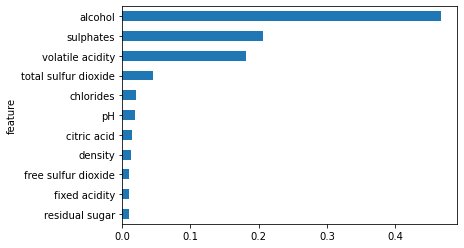

In [9]:
feat_importance.set_index('feature')['importance'].sort_values().plot(kind='barh')

# Inspección de modelo usando SHAP

Ahora vamos a ver lo que podemos obtener con SHAP, y si en primera instancia los valores son similares:

In [10]:
explainer = shap.Explainer(model=model)

In [11]:
shap_values = explainer(X_train)

## Feature importance

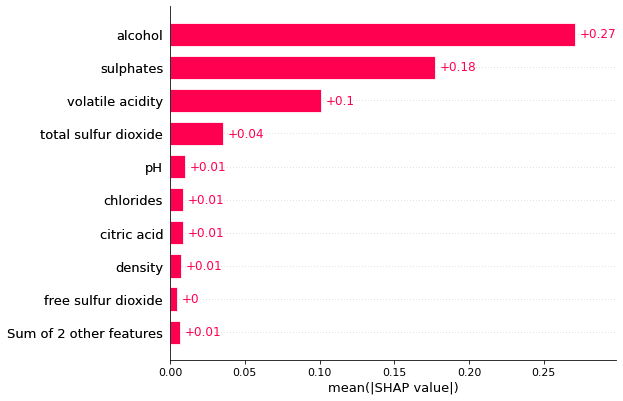

In [12]:
shap.plots.bar(shap_values)

Vemos algún cambio menor, pero en lineas generales los valores son similares, pero de momento, no estamos ganando nada con respecto a la importancia de las variables que nos otorga RandomForest.

Una cosa que podemos hacer con SHAP es obtener el signo del impacto, es decir, saber si las variables tienen un impacto positivo o negativo en el resultado final, vamos a verlo: 

## Summary plot

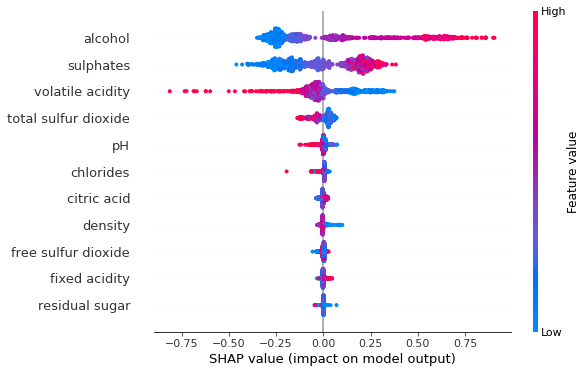

In [13]:
shap.summary_plot(shap_values=shap_values)

En este grafico podemos ver la siguiente información: 

- El eje vertical muestra la importancia de la variable 
- El eje horizontal muestra el efecto de cada punto para la predicción
- El color muestra si el valor de la variable fue alto o bajo

De este modo podemos empezar a entender nuestro modelo, sabiendo por ejemplo que un buen vino tiene: 

  - Alto contenido en alcohol
  - Alto contenido en sulfatos
  - Baja volatilidad con la acided
  - Bajo ph
  - ...

Pero todavía podemos ir mas allá y entender los impactos directos de cada una de las features a una predicción..

In [14]:
shap.plots.force(shap_values[0])  ## el indice es el numero de linea del ejemplo del dataset